### Loading the visual similarity category of blink

In [1]:
from datasets import load_dataset

dataset_name = 'BLINK-Benchmark/BLINK'
data = load_dataset(dataset_name, 'Visual_Similarity')
print(data)

c:\Users\david\anaconda3\envs\blink_new\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    val: Dataset({
        features: ['idx', 'question', 'sub_task', 'image_1', 'image_2', 'image_3', 'image_4', 'choices', 'answer', 'prompt', 'explanation'],
        num_rows: 135
    })
    test: Dataset({
        features: ['idx', 'question', 'sub_task', 'image_1', 'image_2', 'image_3', 'image_4', 'choices', 'answer', 'prompt', 'explanation'],
        num_rows: 136
    })
})


In [2]:
data_val = data['val']
print(data_val)
data_test = data['test']
print(data_test)

print(data_val[0]['question'])
print(data_val[0]['sub_task'])
print(data_val[0]['image_1'])

print(data_val[0]['choices'])
print(data_val[0]['answer'])

Dataset({
    features: ['idx', 'question', 'sub_task', 'image_1', 'image_2', 'image_3', 'image_4', 'choices', 'answer', 'prompt', 'explanation'],
    num_rows: 135
})
Dataset({
    features: ['idx', 'question', 'sub_task', 'image_1', 'image_2', 'image_3', 'image_4', 'choices', 'answer', 'prompt', 'explanation'],
    num_rows: 136
})
Which image is most similar to the reference image?
Visual Similarity
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x22FD6F69810>
['the second image', 'the third image']
(A)


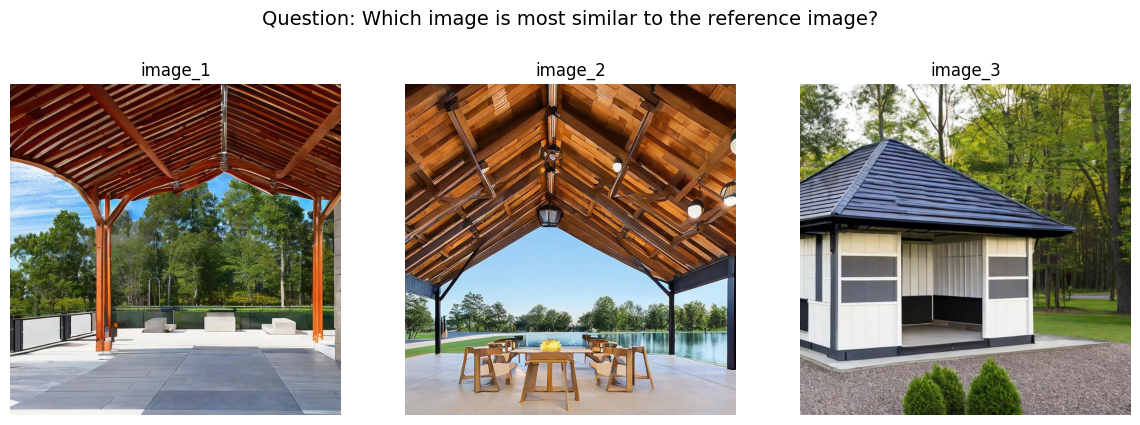

Prompt: Given three similar but different images, take the first image as reference. Can you tell which one of the latter two images is most similar to the first one?
Select from the following choices.
(A) the second image
(B) the third image
Choices:
  A. the second image
  B. the third image

Correct Answer: (A)


In [12]:
import matplotlib.pyplot as plt

def show_question_with_images(data, index):
    example = data[index]
    image_keys = ['image_1', 'image_2', 'image_3', 'image_4']
    
    images = [(key, example[key]) for key in image_keys if example[key] is not None]
    
    # display images in a row
    fig, axes = plt.subplots(1, len(images), figsize=(4 * len(images), 4))
    if len(images) == 1:
        axes = [axes]  
    for ax, (label, img) in zip(axes, images):
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    
    plt.suptitle(f"Question: {example['question']}", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

    # show choices and correct answer
    print("Prompt:", example["prompt"])
    print("Choices:")
    for i, choice in enumerate(example['choices']):
        print(f"  {chr(65 + i)}. {choice}")
    print("\nCorrect Answer:", example['answer'])

    if example.get('explanation'):
        print("\nExplanation:", example['explanation'])

show_question_with_images(data_val, 1)



### Loading the DINOv2 model 

In [7]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
# Load model (run this only once)
model = torch.hub.load(
    'facebookresearch/dinov2', 'dinov2_vits14_reg',
    pretrained=True, force_reload=True, trust_repo=True
).eval().to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to C:\Users\david/.cache\torch\hub\main.zip


In [8]:
preprocess = transforms.Compose([
    transforms.Resize(224), # use 518 for the giant model
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# preprocess = transforms.Compose([
#    transforms.Resize(518, interpolation=transforms.InterpolationMode.BICUBIC),  # Resize to 518px
#     transforms.CenterCrop(518),  # Crop to 518x518
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#])

def extract_features(pil_img):
    img_tensor = preprocess(pil_img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = model(img_tensor)
    return feat.squeeze()

def infer_dinov2_similarity(sample):
    results = []
    img1 = extract_features(sample["image_1"])
    img2 = extract_features(sample["image_2"])
    img3 = extract_features(sample["image_3"])

    sim2 = F.cosine_similarity(img1.unsqueeze(0), img2.unsqueeze(0)).item()
    sim3 = F.cosine_similarity(img1.unsqueeze(0), img3.unsqueeze(0)).item()

        # Choose which is more similar to image_1
    prediction = "image_2" if sim2 >= sim3 else "image_3"
    return "(A)" if prediction == "image_2" else "(B)"

In [9]:
def evaluate(data):
    correct = 0
    total = 0

    for sample in data:
        pred = infer_dinov2_similarity(sample)
        gt = sample['answer']

        print("Predicted answer : ", pred)
        print("Correct answer : ", gt)
        if pred == gt:
            correct += 1
        total += 1
    
    accuracy = correct / total
    return accuracy


accuracy = evaluate(data_val)
print(f"DinoV2  accuracy: {accuracy:.2%}")

Predicted answer :  (A)
Correct answer :  (A)
Predicted answer :  (A)
Correct answer :  (A)
Predicted answer :  (A)
Correct answer :  (A)
Predicted answer :  (A)
Correct answer :  (A)
Predicted answer :  (B)
Correct answer :  (B)
Predicted answer :  (B)
Correct answer :  (B)
Predicted answer :  (A)
Correct answer :  (A)
Predicted answer :  (A)
Correct answer :  (A)
Predicted answer :  (B)
Correct answer :  (B)
Predicted answer :  (A)
Correct answer :  (A)
Predicted answer :  (A)
Correct answer :  (B)
Predicted answer :  (A)
Correct answer :  (A)
Predicted answer :  (B)
Correct answer :  (B)
Predicted answer :  (A)
Correct answer :  (B)
Predicted answer :  (B)
Correct answer :  (B)
Predicted answer :  (A)
Correct answer :  (A)
Predicted answer :  (B)
Correct answer :  (B)
Predicted answer :  (B)
Correct answer :  (B)
Predicted answer :  (B)
Correct answer :  (B)
Predicted answer :  (A)
Correct answer :  (A)
Predicted answer :  (B)
Correct answer :  (B)
Predicted answer :  (A)
Correct an